In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import CorrelatedReadoutError
from qiskit.result import CorrelatedReadoutMitigator
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import BackendSampler

In [4]:
provider.save_account('', overwrite=True)

In [3]:
provider = IBMProvider()
backend = provider.get_backend('ibm_sherbrooke')

sampler = BackendSampler(backend)

In [5]:
# service = QiskitRuntimeService()

# real_backend = service.backend("ibm_sherbrooke")
# backend = AerSimulator.from_backend(real_backend)

In [6]:
provider.active_account()

In [7]:
# Set up the mitigation experiment
qubits = [0,1,2]
num_qubits = len(qubits)
exp1 = CorrelatedReadoutError(qubits)
exp2 = CorrelatedReadoutError(qubits)

# Print mitigation experiment circuits
for c in exp1.circuits():
    print(c)

         ░ ┌─┐      
   q_0: ─░─┤M├──────
         ░ └╥┘┌─┐   
   q_1: ─░──╫─┤M├───
         ░  ║ └╥┘┌─┐
   q_2: ─░──╫──╫─┤M├
         ░  ║  ║ └╥┘
meas: 3/════╩══╩══╩═
            0  1  2 
        ┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        └───┘ ░ └╥┘┌─┐   
   q_1: ──────░──╫─┤M├───
              ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
   q_0: ──────░─┤M├──────
        ┌───┐ ░ └╥┘┌─┐   
   q_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
        ┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        ├───┤ ░ └╥┘┌─┐   
   q_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
   q_0: ──────░─┤M├──────
              ░ └╥┘┌─┐   
   q_1: ──────░──╫─┤M├───
     

MZI POLARIZING BEAM SPLITTER EXPERIMENT SETUP


In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter

In [9]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R')
phi_S = Parameter('phi_S')

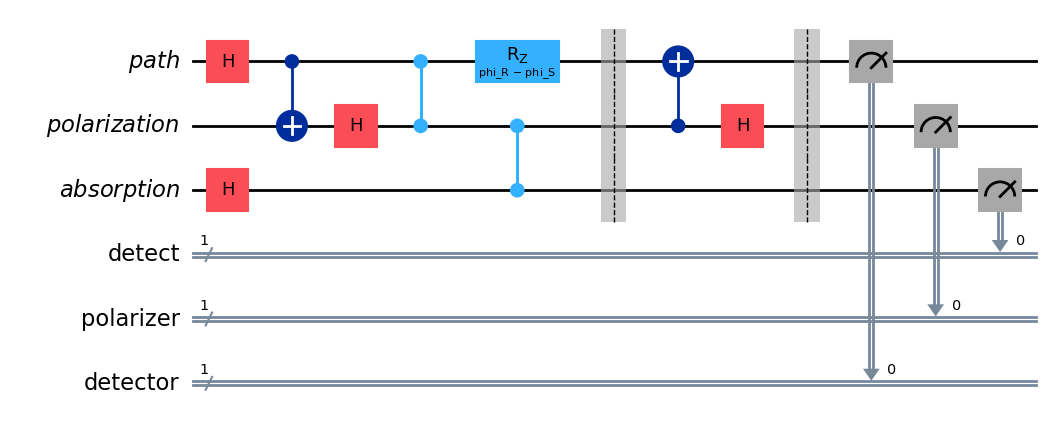

In [10]:
# Create quantum registers name "photon" and "polarization" and a classical bit
qr_photon = QuantumRegister(1, 'path')
qr_polarize = QuantumRegister(1, 'polarization')
qr_absorb= QuantumRegister(1, 'absorption')
cr_detect = ClassicalRegister(1, 'detect')
cr_polarizatoin = ClassicalRegister(1, 'polarizer')
cr_detector = ClassicalRegister(1, 'detector')

# Create a Quantum Circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(qr_photon, qr_polarize, qr_absorb, cr_detect, cr_polarizatoin, cr_detector)

# Polarization BS, creates a superposition and an entanglement with the polarization qubit
qc.h(0)
qc.cx(0,1)

# Phase shift by total of 2π due to the mirrors
# qc.p(pi*2,0)

# Polarizer on each path
qc.h(1)
qc.cz(0,1)
qc.h(2)
qc.cz(2,1)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.rz(phi_R-phi_S,0)
qc.barrier()

# 2nd BS and a phase shift by π
qc.cx(1,0)

# Diagonal Polarizers at Detectors
qc.h(1)

# Measurement on qubit 0 (photon)
qc.barrier()
qc.measure([0,1,2],[2,1,0])

# Draw the circuit
qc.draw('mpl')

In [11]:
# Transpile the circuit
initial_layout = {qc.qubits[0]: 39, qc.qubits[1]: 40, qc.qubits[2]: 41}

qc_trans = transpile(qc, backend, initial_layout=initial_layout)
print(qc_trans)

global phase: 7π/4
                                                                          »
      ancilla_0 -> 0 ─────────────────────────────────────────────────────»
                                                                          »
      ancilla_1 -> 1 ─────────────────────────────────────────────────────»
                                                                          »
      ancilla_2 -> 2 ─────────────────────────────────────────────────────»
                                                                          »
      ancilla_3 -> 3 ─────────────────────────────────────────────────────»
                                                                          »
      ancilla_4 -> 4 ─────────────────────────────────────────────────────»
                                                                          »
      ancilla_5 -> 5 ─────────────────────────────────────────────────────»
                                                                     

In [12]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [13]:
# Assign phase shift params from 0 to 2π, construct a list of circuits
bound_qc = [] 
exp1_qc = []
exp2_qc = []

# Add the mitigation exp circuits in the list prior to the MZI circuits
for i in range(2**num_qubits):
    initial_layout1 = {exp1.circuits()[i].qubits[0]: 39, exp1.circuits()[i].qubits[1]: 40, exp1.circuits()[i].qubits[2]: 41}
    initial_layout2 = {exp2.circuits()[i].qubits[0]: 39, exp2.circuits()[i].qubits[1]: 40, exp2.circuits()[i].qubits[2]: 41}
    trans_exp1_qc = transpile(exp1.circuits()[i], backend, initial_layout=initial_layout1)
    trans_exp2_qc = transpile(exp2.circuits()[i], backend, initial_layout=initial_layout2)
    exp1_qc.append(trans_exp1_qc)
    exp2_qc.append(trans_exp2_qc)

# Add the MZI circuits in the list
for i in range(33):
    param_values = {phi_S: 0, phi_R: (pi/16)*i}
    bound_qc.append(qc_trans.assign_parameters(param_values))

all_qc = exp1_qc + bound_qc + exp2_qc
print(len(all_qc)) # Should be 49 in total = 8 prior mitigation circ + 33 MZI circ + 8 post mitigation circ

49


RUN THE EXPERIMENT

In [14]:
# job = backend.run(all_qc, shots=shots)
# print(job.job_id())

RETRIEVE THE JOB

In [15]:
# Define job id
job_id = 'cte6t0rzw92000833tk0'
job = QiskitRuntimeService().job(job_id)
result = job.result()

In [16]:
# Get Mitigation experitment results
exp1_results = [result.get_counts()[i] for i in range(2**num_qubits)]
exp2_results = [result.get_counts()[41+i] for i in range(2**num_qubits)]


# Takes in mitigation experiment results and contructs a assignment matrix
# Returns an assignment matrix
def generate_assignment_matrix(exp_results):
    state_labels = ['000','001', '010', '011', '100', '101', '110', '111']
    assignment_matrix = np.zeros((2**num_qubits, 2**num_qubits))
    for state_idx, state in enumerate(state_labels):
        counts = exp_results[state_idx]
        for measured_state, count in counts.items():
            measured_idx = state_labels.index(measured_state)
            assignment_matrix[measured_idx, state_idx] = count / shots
    return assignment_matrix

# Construct mitigator objects
mitigator1 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp1_results))
mitigator2 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp2_results))

# Get unmitigated counts
unmitigated_counts_raw = [result.get_counts()[2**num_qubits+i] for i in range(len(bound_qc))]
unmitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_counts_raw]

In [17]:
# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator)  
# Calculates unmitigated probailities, mitigated quasi-probabilities
# Calculates mitigated probabilities with quasi-probabilites on L2 norm
# Calculates mitigated counts
def mitigation_method_1(mitigator):
    unmitigated_probs, mitigated_quasi_probs, mitigated_probs, mitigated_counts = [], [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        mitigated_quasi_probs.append(mitigator.quasi_probabilities(unmitigated_counts[i]))
        mitigated_probs.append(mitigated_quasi_probs[i].nearest_probability_distribution().binary_probabilities())
        mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts


# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator) 
# Calculates unmitigated probailities
# Calculates mitigated quasi-counts by multiplication with inv confusion matrix
# Calculates mitigated counts by throwing away negative counts
# Calculates mitigated probabilites by re-normalizing with new shots #
def mitigation_method_2(mitigator):
    unmitigated_probs, mitigated_probs, mitigated_counts = [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        # Creates a column vector of the counts
        vec_count = np.array([unmitigated_counts[i]['0 0 0'], unmitigated_counts[i]['0 0 1'], unmitigated_counts[i]['0 1 0'], unmitigated_counts[i]['0 1 1'], 
                              unmitigated_counts[i]['1 0 0'], unmitigated_counts[i]['1 0 1'], unmitigated_counts[i]['1 1 0'], unmitigated_counts[i]['1 1 1']])[:, np.newaxis]
        mitigated_quasi_count = np.dot(mitigator.mitigation_matrix(),vec_count)
        # if either count is negative, set it to 0 and calculate the total count
        total_count = 0
        for i in range(len(vec_count)):
            if mitigated_quasi_count[i] < 0:mitigated_quasi_count[i] = 0
            total_count += mitigated_quasi_count[i]
        # Define dictionaries
        dict_count = {
            '000': mitigated_quasi_count[0].item(),
            '001': mitigated_quasi_count[1].item(),
            '010': mitigated_quasi_count[2].item(),
            '011': mitigated_quasi_count[3].item(),
            '100': mitigated_quasi_count[4].item(),
            '101': mitigated_quasi_count[5].item(),
            '110': mitigated_quasi_count[6].item(),
            '111': mitigated_quasi_count[7].item()
        }
        dict_prob = {
            '000': (mitigated_quasi_count[0]/total_count).item(),
            '001': (mitigated_quasi_count[1]/total_count).item(),
            '010': (mitigated_quasi_count[2]/total_count).item(),
            '011': (mitigated_quasi_count[3]/total_count).item(),
            '100': (mitigated_quasi_count[4]/total_count).item(),
            '101': (mitigated_quasi_count[5]/total_count).item(),
            '110': (mitigated_quasi_count[6]/total_count).item(),
            '111': (mitigated_quasi_count[7]/total_count).item()
        }
        mitigated_counts.append(dict_count)
        mitigated_probs.append(dict_prob)
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts  

Unmitigated Counts: 
{'0 0 1': 2146, '1 0 1': 79, '1 0 0': 82, '0 0 0': 1878, '1 1 0': 1783, '0 1 1': 81, '0 1 0': 61, '1 1 1': 2082}
Mitigated Counts: 
{'010': 30, '101': 55, '001': 57, '110': 59, '011': 1826, '000': 1897, '111': 2112, '100': 2156}

Unmitigated Prob: 
{'1 0 0': 0.261962890625, '1 0 1': 0.0096435546875, '0 0 1': 0.010009765625, '0 0 0': 0.229248046875, '0 1 1': 0.2176513671875, '1 1 0': 0.0098876953125, '0 1 0': 0.0074462890625, '1 1 1': 0.254150390625}
Mitigated Prob: 
{'010': 0.0036297208295290725, '101': 0.006692716176390353, '001': 0.006991554606389406, '110': 0.007230595390249602, '011': 0.22286561110595116, '000': 0.2316125245086207, '111': 0.25779948962757077, '100': 0.263177787755299}


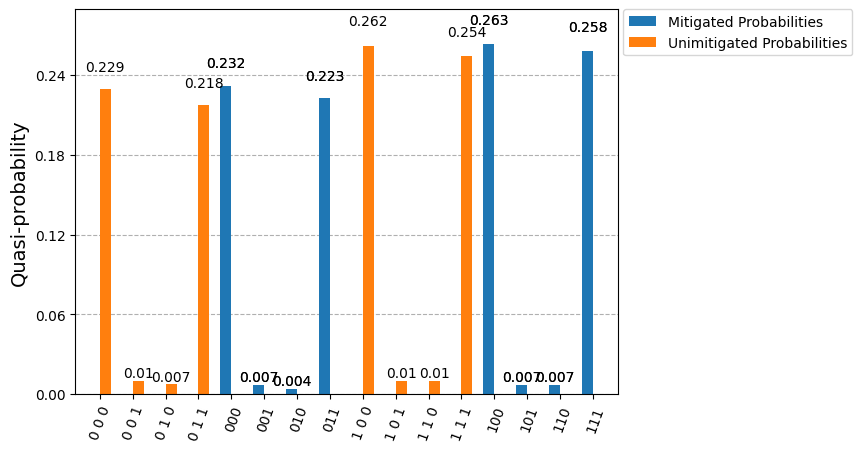

In [18]:
# Pick a mitigation_method (method_1 = least_squares, method_2 = throwaway zeros)
# Parameter: 0 for pre-mitigator, 1 for post-mitigator
unmitigated_probs, mitigated_probs, mitigated_counts = mitigation_method_1(mitigator1)

# Index of a circuit [0:0π 1=π/2, 2=π, 3=3π/2]
i = 0

# Print unmitigated & mitigated counts and plot 

print("Unmitigated Counts: ")
print(unmitigated_counts[i]) 
print("Mitigated Counts: ")
print(mitigated_counts[i])
print("")
print("Unmitigated Prob: ")
print(unmitigated_probs[i])
print("Mitigated Prob: ")
print(mitigated_probs[i])

legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs[i], unmitigated_probs[i]], legend=legend)

SCATTER PLOT OVER ALL ANGLES

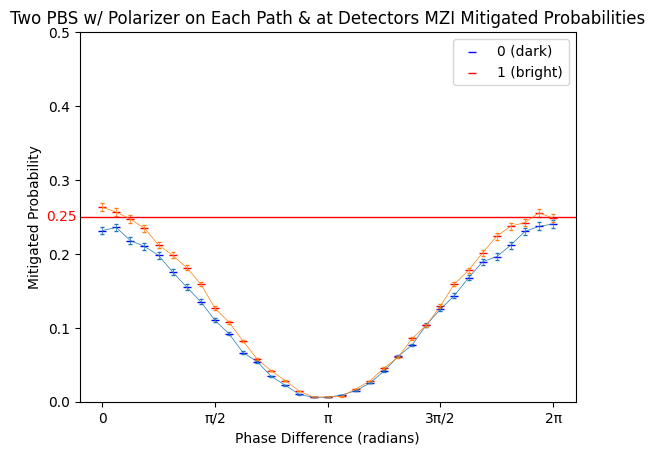

In [19]:
# Extract x, y data 
x = [(pi/16)*i for i in range(len(mitigated_probs))]

# y_0_un = [(d.get('0 0 0', 0)) for d in unmitigated_probs]
# y_1_un = [(d.get('1 0 0', 0))for d in unmitigated_probs]
y_0 = [(d.get('000', 0)) for d in mitigated_probs]
y_1 = [(d.get('100', 0))for d in mitigated_probs]


# Calculate standard error (SE = sqrt(p(1-p)/n)) measures how much the probability varies from the true probability.
y_err = [np.sqrt(y_0[i] * y_1[i]/shots)*1.96 for i in range (len(mitigated_probs))]


# Create a scatter a scatter plot
plt.errorbar(x, y_0, yerr=y_err, capsize=1.7, linewidth = 0.5)
plt.errorbar(x, y_1, yerr=y_err, capsize=1.7, linewidth = 0.5)
plt.scatter(x,y_0, color='blue', label='0 (dark)', marker="_", linewidths=1)
plt.scatter(x,y_1, color='red', label='1 (bright)', marker="_", linewidths=1)

# # plot unmitigated probabilities
# plt.errorbar(x, y_0_un, yerr=y_err, capsize=1.7, linewidth = 0.5)
# plt.errorbar(x, y_1_un, yerr=y_err, capsize=1.7, linewidth = 0.5)
# plt.scatter(x,y_0_un, color='green', label='0 (dark)', marker="_", linewidths=1)
# plt.scatter(x,y_1_un, color='orange', label='1 (bright)', marker="_", linewidths=1)

plt.axhline(y=0.25, color='red', linestyle='-', linewidth=1)
plt.text(-0.35, 0.25, '0.25', color='red', va='center', ha='right')

plt.xlabel('Phase Difference (radians)')
tick_positions = [(pi/2)*i for i in range(5)]
tick_labels = ['0', 'π/2' , 'π', '3π/2', '2π']
plt.xticks(tick_positions, tick_labels)
plt.ylim(0,0.5)
plt.ylabel('Mitigated Probability')
plt.title('Two PBS w/ Polarizer on Each Path & at Detectors MZI Mitigated Probabilities')
plt.legend()